# [COM4513-6513] Assignment 2: Text Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)
- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)
- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**4 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**4 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)
- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparam combination  (**2 marks**). 
- After training the model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy.
- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).

- **BONUS:** Extend you Feedforward network by adding more hidden layers (e.g. one more). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**+2 extra marks**)



### Data 

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. You are allowed to re-use your code from Assignment 1.

Please make sure to comment your code. You should also mention if you've used Windows to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1 of ~75-80% and ~85% without and with using pre-trained embeddings respectively. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module. If you implement the bonus question you can get up to 2 extra points but your final grade will be capped at 20.

The deadline for this assignment is **23:59 on Mon, 18 May 2020** and it needs to be submitted via Blackboard (MOLE). Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from functools import partial
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)

## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
def load_data(folder='topic'):
    """
        Load data from the folder and stor it in the dictionary
        
        Parameters
        ----------
        
        folder: {data_topic}
            name of the folder to extract the data from. (default is to get topic data)
    
    """
    names = ['text', 'label']
    if folder=='topic':
        names = names[::-1]
    all_data = {}
    for file in ['train', 'dev', 'test']:
        all_data[file] = pd.read_csv(f'data_{folder}/{file}.csv', names=names)
    return all_data

def get_raw_data(data_files):
    """
        Converts pandas data to lists
        
        Parameters
        ----------
        data_files: dict
            Dictionary containing pandas dataframes read from the data files
    """
    raw_data = {}
    for key, value in data_files.items():
        raw_data[f'X_{key}'] = value.text.values.tolist()
        raw_data[f'y_{key}'] = value.label.values
    return raw_data

In [3]:
raw_data = get_raw_data(load_data())

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [4]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [5]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=set(), vocab=set()):
    """
        Extracts ngram representation of the text data from a string
        
        Parameters
        ----------
        x_raw: str
            String representign a single text file
            
        ngram_range: tuple, optional
            range for ngrams to return (default is (1, 3) means unigrams, bigrams and trigrams will be returned)
            
        token_pattern: str, optional
            a partern for regex to split the string into tokens
        
        stop_words: set, optional
            tokens to get rid of (default is empty meaning all tokens will be kept)
            
        vocab: set, optional
            a set of ngrams that should be kept (default is empty returning all ngrams)
    """
    
    # Tokenise the text
    tokens = re.findall(token_pattern, x_raw.lower()) # lowercase to reducde number of unique tokens
    
    # Remove the stop words
    no_stop = [word for word in tokens if word not in stop_words]
    
    # Create ngrams
    if ngram_range[0] == 1:
        ngram_range = (ngram_range[0]+1, ngram_range[1])
        ngrams = no_stop.copy()
    else:
        ngrams = []
        
    for n in range(ngram_range[0], ngram_range[1]+1):
        ngrams += zip(*[no_stop[i:] for i in range(n)])
    
    # Keep only ngrams that are in vocab:
    if vocab:
        ngrams = [ngram for ngram in ngrams if ngram in vocab]
        
    return ngrams

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [6]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, stop_words=set()):
    
    """
        Extracts the full vocabluary of ngrams from a list of strings (texts)
        
        Parameters
        ----------
        X_raw: list[dtype=str]
            String to extrac the vocabluary from
            
        ngram_range: tuple, optional
            range for ngrams to return (default is (1, 3) means unigrams, bigrams and trigrams will be returned)
            
        token_pattern: str, optional
            a partern for regex to split the string into tokens
        
        stop_words: set, optional
            tokens to get rid of (default is empty meaning all tokens will be kept)
            
        min_df: int, optional
            minimum document frequency to keep the ngram in the vocabluary (default is 0 to keep all ngrams)
            
        keep_topN: int, optinal
            keep only top number of occuring ngrams (default is 0 to keep all ngrams)
    """
    
    df = Counter() 
    ngram_counts = Counter()
    
    # Extract the full vocabluary:
    for x in X_raw:
        ngrams = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, stop_words=stop_words)
        ngram_counts.update(ngrams)
        df.update(set(ngrams))
    
    # Keep only ngrams that occur in certain number of documents
    if min_df:
        df = Counter({k: v for k, v in df.items() if v >= min_df})
        ngram_counts = Counter({k: v for k, v in ngram_counts.items() if k in df.keys()})
    
    # Keep only ngrams that are common overall
    if keep_topN and keep_topN < len(df.keys()):
        ngram_counts = Counter(dict(ngram_counts.most_common()[:keep_topN]))
        df = Counter({k: v for k, v in df.items() if k in ngram_counts.keys()})
                
    return list(df.keys()), df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
vocab, df, ngram_counts = get_vocab(raw_data['X_train'], ngram_range=(1,1), stop_words=stop_words, keep_topN = 5000)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['new', 'remove', 'hugo', 'wing', 'out', 'referendum', 'him', 'historic', 'vote', 'chavez', 'two', 'give', 'numbers', 'next', 'left', 'office', 'either', 'venezuelans', 'president', 'large', 'sunday', 'mandate', 'govern', 'reuters', 'years', 'turned', 'early', 'controversial', 'send', 'seoul', 'more', 'korean', 'water', 'police', 'troops', 'used', 'protesters', 'south', 'government', 'central', 'decision', 'urging', 'disperse', 'cannon', 'reverse', 'least', 'iraq', 'thousands', 'jails', 'said', 'care', 'minister', 'better', 'began', 'starved', 'death', 'conditions', 'israel', 'hunger', 'didn', 'israeli', 'security', 'palestinian', 'strike', 'prisoners', 'afp', 'overnight', 'violation', 'fragile', 'servicemen', 'disputed', 'georgian', 'wounding', 'gunfire', 'took', 'ossetia', 'ceasefire', 'seven', 'place', 'sporadic', 'region', 'shelling', 'armed', 'black', 'against', 'area', 'african', 'deployed', 'soldiers', 'flew', 'sudan', 'foreign', 'into', 'ap', 'troubled', 'farmers', 'killi

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [8]:
id_word = dict(zip(range(len(vocab)), vocab))
word_id = dict(zip(vocab, range(len(vocab))))

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [9]:
ngram_partial = partial(extract_ngrams, stop_words=stop_words, vocab=set(vocab))

ngram_data = {}
for key, value in raw_data.items():
    if key.startswith('X'):
        ngram_data[key] = list(map(ngram_partial, value))
    else:
        ngram_data[key] = value

In [10]:
ngram_data['X_train'][0]

['reuters',
 'venezuelans',
 'turned',
 'out',
 'early',
 'large',
 'numbers',
 'sunday',
 'vote',
 'historic',
 'referendum',
 'either',
 'remove',
 'left',
 'wing',
 'president',
 'hugo',
 'chavez',
 'office',
 'give',
 'him',
 'new',
 'mandate',
 'govern',
 'next',
 'two',
 'years']

Then convert them into lists of indices in the vocabulary:

In [11]:
word_to_id = lambda l : [word_id[w] for w in l]
for key, value in ngram_data.items():
    if key.startswith('X'):
        ngram_data[key] = list(map(word_to_id, ngram_data[key]))

In [12]:
ngram_data['X_train'][1]

[23,
 37,
 31,
 33,
 35,
 32,
 43,
 39,
 29,
 20,
 42,
 45,
 36,
 41,
 38,
 44,
 27,
 40,
 28,
 30,
 34,
 46]

Put the labels `Y` for train, dev and test sets into arrays: 

#### Puting data extraction procedure together:

In [13]:
def get_data(folder, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
             min_df=0, keep_topN=0, stop_words=set()):
    """
        Combines data extraction procedure into a single method
        
        Parameters
        ----------
        folder: str
            name of the folder to extract the data from
        
        tfidf: bool, optional
            determines tfidf should be used or not (defaults to False)
            
        ngram_range: tuple, optional
            range for ngrams to return (default is (1, 3) means unigrams, bigrams and trigrams will be returned)
            
        token_pattern: str, optional
            a partern for regex to split the string into tokens
        
        stop_words: set, optional
            tokens to get rid of (default is empty meaning all tokens will be kept)
            
        min_df: int, optional
            minimum document frequency to keep the ngram in the vocabluary (default is 0 to keep all ngrams)
            
        keep_topN: int, optinal
            keep only top number of occuring ngrams (default is 0 to keep all ngrams)
            
        Returns
        -------
        data_dict: dict
            Dictionary with all data splits, vocabluary and word_id, id_word mappings.
    """
    data_dict = {}
    
    data_files = load_data(folder=folder)
    raw_data = get_raw_data(data_files)
    
    vocab, df, ngram_counts = get_vocab(raw_data['X_train'], ngram_range=ngram_range, stop_words=stop_words,
                                       token_pattern=token_pattern, min_df=min_df, keep_topN=keep_topN)
    
    id_word = dict(zip(range(len(vocab)), vocab))
    word_id = dict(zip(vocab, range(len(vocab))))
    
    ngram_partial = partial(extract_ngrams, stop_words=stop_words, vocab=set(vocab))
    word_to_id = lambda l : [word_id[w] for w in l]
    
    for key, value in raw_data.items():
        if key.startswith('X'):
            word_vec = list(map(ngram_partial, value))
            id_vec = list(map(word_to_id, word_vec))
            # Keep only non-empty documents:
            keep_idx, id_vec = map(list, zip(*[(i, x) for i, x in enumerate(id_vec) if x]))
            data_dict[key] = id_vec
        else:
            data_dict[key] = value[keep_idx]
    
    data_dict['id_word'] = id_word
    data_dict['word_id'] = word_id
    data_dict['vocab'] = np.array(vocab)
    
    return data_dict

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W^T) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i^T $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers (for the Bonus). Empty if there are no hidden layers between the average embedding and the output layer 
- `num_clusses`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

See the examples below for expected outputs. Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [14]:
def network_weights(vocab_size=1000, embedding_dim=300, hidden_dim=[], num_classes=3, init_val=0.1):
    W = {}
    
    dist = partial(np.random.uniform, -init_val, init_val)
    sizes = [vocab_size, embedding_dim] + hidden_dim + [num_classes]
    
    for i in range(len(sizes) - 1):
        W[i] = dist(size=(sizes[i], sizes[i+1])).astype(np.float32)

    return W

In [15]:
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=2)

print('W_emb:', W[0].shape)
print('W_out:', W[1].shape)

W_emb: (5, 10)
W_out: (10, 2)


In [16]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

In [17]:
print('W_emb:', W[0].shape)
print('W_h1:', W[1].shape)
print('W_out:', W[2].shape)

W_emb: (3, 4)
W_h1: (4, 2)
W_out: (2, 2)


In [18]:
W[0]

array([[-0.08085749,  0.07706536,  0.02544979,  0.04468327],
       [-0.09677416,  0.01888638,  0.01135704, -0.06820807],
       [-0.06938589,  0.03910591, -0.03624671,  0.03839406]],
      dtype=float32)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. It takes as input:

- `z`: array of real numbers 

and returns:

- `sig`: the softmax of `z`

In [19]:
def softmax(z, axis=None):
    exp = np.exp(z)
    den = np.sum(exp, axis=axis)
    den = den.reshape(-1, 1) if axis else den
    return exp/den

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:

In [20]:
def to_categorical(arr, num_classes):
    return np.eye(num_classes)[arr-1]

In [21]:
def categorical_loss(y, y_pred):
    y_cat = to_categorical(y, y_pred.shape[-1])
    if np.isscalar(y_cat[0]):
        y_cat = np.array([y_cat])
    l = -y_cat * np.log(y_pred)
    return np.mean(np.sum(l, axis=1))

In [22]:
def predict_class(prob):
    return np.argmax(prob, axis=1) + 1

In [23]:
# example for 5 classes
y = 2 #true label
y_preds = softmax(np.array([[-2.1,1.,0.9,-1.3,1.5]]))

print('y_preds: ',y_preds)
print('loss:', categorical_loss(y, y_preds))

y_preds:  [[0.01217919 0.27035308 0.24462558 0.02710529 0.44573687]]
loss: 1.3080264848567502


Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network (during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

\begin{equation}
  \text{relu_derivative}(z_i)=\begin{cases}
    0, & \text{if $z_i<=0$}.\\
    1, & \text{otherwise}.
  \end{cases}
\end{equation}

Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [24]:
def relu(z):
    return np.maximum(z, 0, z.copy())
    
def relu_derivative(z):
    return np.heaviside(z, 0)

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [25]:
def dropout_mask(size, dropout_rate):
    return np.random.binomial(1, 1-dropout_rate, size)

In [26]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1 1 1 1 1 1 1 1 1 1]
[1 1 0 1 0 1 1 1 1 0]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [27]:
def forward_pass(x, W, dropout_rate=0.2):
    
    out_vals = {}
    out_vals['h'] = []
    out_vals['a'] = []
    out_vals['dropout_vec'] = []
    
    # Ensure x is list of lists:
    if np.isscalar(x[0]):
        x = [x]
        axis = None  # Axis to perform softmax over
    else:
        axis = 1
        
    for i, w in W.items():
        if not i:  # Calculate embeding:
            x = np.array([np.sum(w[x_i], axis=0)/len(x_i) for x_i in x])
        else:
            x = np.dot(x, w)
            
        if i != (len(W) - 1):  # unless last layer
            out_vals['h'].append(x)
            x = relu(x)
            out_vals['a'].append(x)
            if dropout_rate:
                drop = dropout_mask(len(x[0]), dropout_rate)
                out_vals['dropout_vec'].append(drop)
                x *= drop
        else:  # Calculate output
            y = softmax(x, axis=axis)
            out_vals['y'] = y
        
    return out_vals

In [28]:
W = network_weights(vocab_size=3, embedding_dim=4, hidden_dim=[5], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

print()
print(forward_pass([2,1], W, dropout_rate=0.1))

Shape W0 (3, 4)
Shape W1 (4, 5)
Shape W2 (5, 2)

{'h': [array([[-0.07048225,  0.05083556,  0.0807253 ,  0.01912668]],
      dtype=float32), array([[-0.00537986, -0.00211071,  0.00318677,  0.00552425, -0.00987258]],
      dtype=float32)], 'a': [array([[0.        , 0.05083556, 0.0807253 , 0.01912668]], dtype=float32), array([[0.        , 0.        , 0.00318677, 0.00552425, 0.        ]],
      dtype=float32)], 'dropout_vec': [array([1, 1, 1, 1]), array([1, 1, 1, 1, 1])], 'y': array([[0.4998965, 0.5001035]], dtype=float32)}


The `backward_pass` function computes the gradients and update the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [29]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    
    dW = []  # Store weight updates
    
    y = to_categorical(y, out_vals['y'].shape[-1])
    
    # Compute outer layer gradient:
    grad = out_vals['y'] - y
    dW_out = np.dot(out_vals['a'][-1].T, grad)
    dW.append(dW_out)
    
    # Propagate back to the next layer
    grad = np.dot(grad, W[len(W)-1].T)
    
    for l in list(W.keys())[::-1][1:]:
        
        # Multiply by dropout applied durning training:
        if out_vals['dropout_vec']:
            grad = grad * out_vals['dropout_vec'][l]
        
        # Derivative with respect to activation:
        grad *= relu_derivative(out_vals['h'][l])
    
        if l: # Unless first layer
            # Compute hidden layer update
            dW_hid = np.dot(out_vals['a'][l-1].T, grad)
            dW.append(dW_hid)
            # Propagate back to the next layer
            grad = np.dot(grad, W[l].T)
            
        else:  # Update the embeding weights
            if not freeze_emb:
                count = Counter(x)
                # Only calculate gradient for activated inputs:
                dW_in = (np.array(list(count.values())).reshape(-1, 1) * grad) / len(x)
                # Can update straight away as W[0] won't be reused
                W[0][list(count.keys())] -= lr * dW_in
    
    # Update the weights:
    for i in range(len(dW)):
        W[i+1] -= lr * dW.pop()
        
    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [30]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    """
        Performs Stochastic Gradient Descent optimization for classification task with a Neural Net

        Parameters
        ----------
        X_tr: np.array
            Training input data

        Y_tr: np.array
            Training labels (first dimension should be equivalent to X_tr)
            
        W: dict
            Initialised weights for each of the layers in Neural Network

        X_dev: np.array, optional
            Development input data for calculation of validation loss 

        Y_dev: np.array, optional
            Development labels (only used if X_dev is suplied)

        dropout: float, (0, 1)
            Percentage of neurons to cut out between the hidden layers (regularization)

        lr: float, optional
            Learning rate to use durning training (default to optimal parameter determined durning hyperparameter optimization)

        epochs: int, optional
            Number of times to go over full dataset (defaults to optimal)

        tolerance: float, optional
            Difference between concurent development losses at which to stop the training (default to 0.0001)
            
        freeze_emb: bool, optional
            Determines if to freeze the first layer of the network durning training

        print_progress: bool, optional
            Determines if to print the updates for each epoch (default to True)
    """
    
    training_loss_history = []
    validation_loss_history = []
    
    n_points = len(X_tr)
    
    for epoch in range(epochs):
        
        rand_idx = np.random.permutation(n_points)
        
        # Peform the update
        for i in rand_idx:
            out_vals = forward_pass(X_tr[i], W, dropout_rate=dropout)
            W = backward_pass(X_tr[i], Y_tr[i], W, out_vals, lr=lr, freeze_emb=freeze_emb)
        
        # Calculate training loss for epoch
        tr_pred = forward_pass(X_tr, W, dropout_rate=0)['y']
        tr_loss = categorical_loss(Y_tr, tr_pred)
        training_loss_history.append(tr_loss)
        
        # Calcualte validation loss for epoch
        if len(X_dev):
            val_pred = forward_pass(X_dev, W, dropout_rate=0)['y']
            val_loss = categorical_loss(Y_dev, val_pred)
            validation_loss_history.append(val_loss)
        
        if print_progress:
            if len(X_dev):
                print(f'Epoch: {epoch}| Training Loss: {tr_loss:.3f}| Validation loss: {val_loss:.3f}')
            else:
                print(f'Epoch: {epoch}| Training Loss: {tr_loss:.3f}|')
        
        if epoch and len(X_dev) and tolerance:
            if (validation_loss_history[-2] - val_loss) < tolerance:
                break

    return W, training_loss_history, validation_loss_history, epoch+1

Now you are ready to train and evaluate you neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [31]:
data = get_data('topic', ngram_range=(1,1), keep_topN=5000, stop_words=stop_words)
W = network_weights(vocab_size=len(data['vocab']), embedding_dim=300, hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss, _ = SGD(data['X_train'], data['y_train'], W, 
                           X_dev=data['X_dev'], Y_dev=data['y_dev'],
                           lr=0.005, epochs=150, dropout=0.4, tolerance=0.0001,
                           freeze_emb=False)

Shape W0 (5000, 300)
Shape W1 (300, 3)
Epoch: 0| Training Loss: 1.098| Validation loss: 1.098
Epoch: 1| Training Loss: 1.097| Validation loss: 1.098
Epoch: 2| Training Loss: 1.096| Validation loss: 1.097
Epoch: 3| Training Loss: 1.096| Validation loss: 1.097
Epoch: 4| Training Loss: 1.095| Validation loss: 1.096
Epoch: 5| Training Loss: 1.094| Validation loss: 1.096
Epoch: 6| Training Loss: 1.093| Validation loss: 1.095
Epoch: 7| Training Loss: 1.092| Validation loss: 1.095
Epoch: 8| Training Loss: 1.091| Validation loss: 1.094
Epoch: 9| Training Loss: 1.089| Validation loss: 1.093
Epoch: 10| Training Loss: 1.088| Validation loss: 1.092
Epoch: 11| Training Loss: 1.087| Validation loss: 1.092
Epoch: 12| Training Loss: 1.085| Validation loss: 1.091
Epoch: 13| Training Loss: 1.084| Validation loss: 1.090
Epoch: 14| Training Loss: 1.082| Validation loss: 1.089
Epoch: 15| Training Loss: 1.080| Validation loss: 1.088
Epoch: 16| Training Loss: 1.078| Validation loss: 1.087
Epoch: 17| Training

Plot the learning process:

In [32]:
def plot_results(losses, labels):
    for i, loss in enumerate(losses):
        plt.plot(loss, label=labels[i])
    plt.xlabel('Epoch')
    plt.ylabel('Binary Loss')
    plt.title('Loss trough Training')
    plt.legend()
    plt.draw()

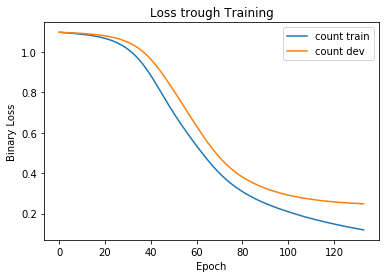

In [33]:
plot_results([loss_tr, dev_loss], ['count train', 'count dev'])

In [34]:
print(f'Difference between final development and training loss is {dev_loss[-1] - loss_tr[-1]}')

Difference between final development and training loss is 0.1296248079242911


Compute accuracy, precision, recall and F1-Score:

In [35]:
def evaluation_metrics(actual, predicted, average='binary'):
    acc = accuracy_score(actual, predicted)
    prec = precision_score(actual, predicted, average=average)
    rec = recall_score(actual, predicted, average=average)
    f1 = f1_score(actual, predicted, average=average)
    
    return [acc, prec, rec, f1]

In [36]:
pred = predict_class(forward_pass(data['X_test'], W, dropout_rate=0)['y'])
metrics = evaluation_metrics(data['y_test'], pred, average ='macro')

results = pd.DataFrame(data=metrics, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'], columns=['Avr Embeding'])
results.round(3)

,Avr Embeding
Accuracy,0.864
Precision,0.867
Recall,0.864
F1-Score,0.864


### Discuss how did you choose model hyperparameters ? 

In [37]:
def optimize(data, lr_range, drop_range, layer_sizes, n_itter=100, hidden_range=[0], w_glove=None):
    
    columns = ['lr', 'epoch', 'dropout', 'embeding']
    for i in range(max(hidden_range)):
        columns.append(f'hidden_{i+1}')
    columns += ['dev_loss', 'F1']
        
    results = []
    
    # Print top row:
    str_len = []
    top_str = ''
    for c in columns:
        g = int((12 - len(c))/2) 
        entry = '|' + g*' ' + str(c) + g*' '
        top_str += entry
        str_len.append(len(entry))
    print(top_str + '|')
    
    min_dev_loss = 1
    
    for i in range(n_itter):
        
        hidden = []
        
        lr = random.choice(lr_range)
        dropout = random.choice(drop_range)
        n_hidden = random.choice(hidden_range)
        
        if w_glove is None:
            embeding = random.choice(layer_sizes)
        else:
            embeding = 300
        
        for h in range(n_hidden):
            hidden.append(random.choice(layer_sizes))
        
        res = opt_run(data, lr, dropout, embeding, hidden, max(hidden_range), w_glove=w_glove)
        results.append(res)

        # Print out results for current itteration:
        if res[-2] < min_dev_loss:
            min_dev_loss = res[-2]
            res_str = '\x1b[95m'
            esc = '\x1b[0m'
        else:
            res_str = ''
            esc = ''
        for i, r in enumerate(res):
            v_s = f'{res[i]}'
            v_s = v_s if len(v_s) < 5 else v_s[:6]
            g = int(np.floor((12 - len(v_s))/2))
            res_str += '|' + g*' ' + v_s + (str_len[i]-g-len(v_s)-1)*' '
        print(res_str + '|' + esc)
                        
    return pd.DataFrame(data=np.vstack(results), columns=columns)

def opt_run(data, lr, dropout, embeding, hidden, n_hidden, w_glove=None):
    
    W = network_weights(vocab_size=len(data['vocab']), embedding_dim=embeding, hidden_dim=hidden, num_classes=3)
    
    if w_glove is not None:
        W[0] = w_glove
        freeze_emb = True
    else:
        freeze_emb = False
        
    W, loss_tr, dev_loss, e = SGD(data['X_train'], data['y_train'], W, 
                               X_dev=data['X_dev'], Y_dev=data['y_dev'],
                               lr=lr, epochs=200, dropout=dropout, tolerance=0.0001,
                               freeze_emb=freeze_emb, print_progress=False)
    
    pred = predict_class(forward_pass(data['X_dev'], W, dropout_rate=0)['y'])
    metrics = evaluation_metrics(data['y_dev'], pred, average ='macro')
    
    res = [lr, e, dropout, embeding]
    for h in range(n_hidden):
        try:
            res.append(hidden[h])
        except:
            res.append('-')
    res += [dev_loss[-1], metrics[-1]]
    
    return res

In [ ]:
lr_range = np.linspace(0.001, 0.01, 10)
drop_range = np.linspace(0.1, 0.5, 5)
layer_sizes = np.linspace(200, 400, 5).astype(int)

opt_results_ = optimize(data, lr_range, drop_range, layer_sizes, n_itter=100)

|     lr     |   epoch   |  dropout  |  embeding  |  dev_loss  |     F1     |
|   0.001    |    200    |   0.3000  |    350     |   0.8499   |   0.7771   |
|   0.005    |    150    |    0.1    |    350     |   0.2627   |   0.9008   |
|   0.0090   |     83    |    0.5    |    300     |   0.2515   |   0.9207   |
|   0.001    |    200    |    0.2    |    300     |   0.7819   |   0.8403   |
|   0.0090   |     78    |   0.3000  |    250     |   0.2437   |   0.9207   |
|   0.001    |    200    |    0.4    |    400     |   0.9368   |   0.8013   |
|   0.007    |    109    |    0.1    |    300     |   0.2520   |   0.9143   |
|   0.008    |     89    |    0.1    |    200     |   0.2527   |   0.9008   |
|   0.003    |    200    |    0.2    |    300     |   0.2660   |   0.9143   |
|   0.007    |    106    |    0.5    |    300     |   0.2477   |   0.9207   |
|   0.008    |     89    |    0.1    |    300     |   0.2498   |   0.9143   |
|   0.0090   |     81    |    0.4    |    400     |   0.2584   |

In [ ]:
opt_results_.sort_values('dev_loss').head(3)

In [ ]:
plot_columns = ['lr', 'epoch', 'dropout', 'embeding']
for c in columns:
    opt_results_.plot.scatter(x=c, y='dev_loss', c='F1', colormap='Blues', sharex=False)     

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary.

In [ ]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [ ]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt", word_id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [ ]:
W = network_weights(vocab_size=len(data['vocab']), embedding_dim=300, hidden_dim=[], num_classes=3)
W[0] = w_glove

W, loss_tr, dev_loss, _ = SGD(data['X_train'], data['y_train'], W, 
                           X_dev=data['X_dev'], Y_dev=data['y_dev'],
                           lr=0.004, epochs=200, dropout=0.3, tolerance=0.0001,
                           freeze_emb=True)

In [ ]:
pred = predict_class(forward_pass(data['X_test'], W, dropout_rate=0)['y'])
metrics = evaluation_metrics(data['y_test'], pred, average ='macro')

results['Pre-Trained Embeding'] = metrics
results.round(3)

### Discuss how did you choose model hyperparameters ? 

In [ ]:
lr_range = np.linspace(0.001, 0.005, 5)
drop_range = np.linspace(0.1, 0.5, 5)
layer_sizes = []

opt_results_ = optimize(data, lr_range, drop_range, layer_sizes, n_itter=100, w_glove=w_glove)

In [ ]:
opt_results_emb.sort_values('dev_loss').head(5)

In [ ]:
plot_columns = ['lr', 'epoch', 'dropout']
for c in columns:
    opt_results_emb.plot.scatter(x=c, y='dev_loss', c='F1', colormap='Blues', sharex=False)

# Extend to support deeper architectures (Bonus)

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. 

In [ ]:
data = get_data('topic', ngram_range=(1,1), keep_topN=5000, stop_words=stop_words)
W = network_weights(vocab_size=len(data['vocab']), embedding_dim=300, hidden_dim=[300], num_classes=3)
W[0] = w_glove

W, loss_tr, dev_loss, _ = SGD(data['X_train'], data['y_train'], W, 
                           X_dev=data['X_dev'], Y_dev=data['y_dev'],
                           lr=0.004, epochs=200, dropout=0.3, tolerance=0.0001,
                           freeze_emb=True)

In [ ]:
pred = predict_class(forward_pass(data['X_test'], W, dropout_rate=0)['y'])
metrics = evaluation_metrics(data['y_test'], pred, average ='macro')

results['Pre-trained Embeding + 1 Hidden'] = metrics
results.round(3)

In [ ]:
lr_range = np.linspace(0.0001, 0.0005, 5)
drop_range = np.linspace(0.1, 0.5, 5)
layer_sizes = np.linspace(200, 400, 5).astype(int)
hidden_range = [1, 2]

opt_results_emb = optimize(data, lr_range, drop_range, layer_sizes, n_itter=100, hidden_range=hidden_range, w_glove=w_glove)

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |   |   |   |   |
| Average Embedding (Pre-trained)  |   |   |   |   |
| Average Embedding (Pre-trained) + X hidden layers (BONUS)   |   |   |   |   |
